In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import os, sys
import json
from os import listdir
from os.path import isfile, join
import shutil 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from random import randrange
from random import shuffle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import scipy.io

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
!nvidia-smi

Sun Dec 11 12:55:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")

tf.keras.mixed_precision.global_policy()

<Policy "mixed_float16">

In [ ]:
is_download_cihp_dataset = True

run_model_parsing_1 = False

In [ ]:
saved_models_path = '/content/gdrive/MyDrive/Saved-Models'

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
def get_file_paths_at_index(root_dir, index=0):

  """
  get a list of datapoints at an index from each sub directory
  """
  
  if os.path.exists(root_dir):

    result_files = []
    for root, dirs, files in os.walk(root_dir):
        if files and len(files) > index:
            result_files.append(os.path.join(root, sorted(files)[index]))

    return sorted(result_files)

  else:
    print('No such directory found: ', root_dir)

In [ ]:
def move_all_files_and_sub_dirs(source, destination):

  """
  Moves all files and sub-directories at root level of a directory to another place 
  along with all there contents
  """

  root_dir = list(os.walk(source))[0][0]
  sub_dir_and_files = [os.path.join(root_dir, i) for i in (list(os.walk(source))[0][1] + list(os.walk(source))[0][2])]

  for item in sub_dir_and_files:

    shutil.move(item, destination)

In [ ]:
%%time
if is_download_cihp_dataset:

  !pip install --upgrade --no-cache-dir gdown

  !wget https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
  !gdown 1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

  !unzip -q /content/instance-level-human-parsing.zip -d CIHP

  # Remove ATR dataset as we do not need it
  shutil.rmtree('/content/CIHP/ICCV15_fashion_dataset(ATR)')

  # Move CIHP dataset folders from tree of sub-dirs to dir "/content/CIHP"
  move_all_files_and_sub_dirs('/content/CIHP/instance-level_human_parsing/instance-level_human_parsing', '/content/CIHP')

  # Remove empty directories from dataset
  shutil.rmtree('/content/CIHP/instance-level_human_parsing') 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
--2022-12-11 12:55:40--  https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
Resolving drive.google.com (drive.google.com)... 142.251.12.102, 142.251.12.113, 142.251.12.139, ...
Connecting to drive.google.com (drive.google.com)|142.251.12.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz’

uc?id=1B9A9UCJYMwTL     [ <=>                ]   2.22K  --.-KB/s    in 0s      

2022-12-11 12:55:42 (32.2 MB/s) - ‘uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz’ saved [2275]

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:36<00:00, 80.4MB/s]
C

In [ ]:
def get_files_in_dir(dir_path):

  """
  Return a list of file names in a given directory
  """

  if os.path.exists(dir_path):
    files = sorted([f for f in listdir(dir_path) if isfile(join(dir_path, f))])
    return files

  else:
    print('No such directory found: ', dir_path)

In [ ]:
def merge_two_list(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

In [ ]:
def shuffle_and_ratio_data(images, masks, image_root_path, mask_root_path, dataset_ratio=1):

  images_len = len(images)
  masks_len = len(masks)

  # make image and masks tuples, shuffle the data and then return given percentage of that data
  image_mask_tuples = merge_two_list(images, masks)
  shuffle(image_mask_tuples)
  image_mask_tuples_per = image_mask_tuples[:int(images_len * dataset_ratio)]

  images_result = [os.path.join(image_root_path, x[0]) for x in image_mask_tuples_per]
  masks_result = [os.path.join(mask_root_path, x[1]) for x in image_mask_tuples_per]

  return images_result, masks_result

In [ ]:
def get_color_map_and_labels():

  # class labels
  # background was not mentioned in readme file but its color code was present in mat file at first index
  class_labels = [
      "Background", # 0
      "Hat", # 1
      "Hair", # 2
      "Glove", # 3
      "Sunglasses", # 4 
      "UpperClothes", # 5, shirt
      "Dress", # 6, wore by women like formal with short+pant
      "Coat", # 7
      "Socks", # 8
      "Pants", # 9
      "Torso-skin", # 10, means neck
      "Scarf", # 11
      "Skirt", # 12
      "Face", # 13
      "Left-arm", # 14
      "Right-arm", # 15
      "Left-leg", # 16
      "Right-leg", # 17
      "Left-shoe", # 18
      "Right-shoe", # 19
  ]

  # color map
  # by default color map in given file is in bgr formate
  color_map_array = scipy.io.loadmat('/content/CIHP/human_colormap.mat')['colormap']

  bgr_color_map = np.array(color_map_array*256, dtype=np.uint8)

  rgb_color_map = np.array([[i[2], i[1], i[0]] for i in bgr_color_map])

  return class_labels, bgr_color_map, rgb_color_map

In [ ]:
def grayscale_to_rgb(mask_grey_scale, classes, color_map):
    h, w = mask_grey_scale.shape
    mask_grey_scale = mask_grey_scale.astype(np.int32)
    mask_rgb = []

    # flatten the grey-scale image and map every pixel to colormap and then re-construct the rgb mask image
    for i, px in enumerate(mask_grey_scale.flatten()):
        mask_rgb.append(color_map[px])

    mask_rgb = np.reshape(mask_rgb, (h, w, 3))
    return mask_rgb

In [ ]:
def calculate_score_for_human_parsing_pred(pred_mask, true_mask, n_classes):

  labels = [i for i in range(n_classes)]

  true_mask = true_mask.flatten()
  pred_mask = pred_mask.flatten()

  f1_score_pred = f1_score(true_mask, pred_mask, labels=labels, average=None, zero_division=0)

  return {'f1_score': f1_score_pred}

In [ ]:
def plot_and_predict_model(color_map, class_labels, model):

  random_index = randrange(len(test_x)-1)

  # image_path, mask_path = get_img_and_label_by_index(vton_test_dir, 16)

  image_path = test_x[random_index]
  mask_path = test_y[random_index]

  # predicting the results
  pred_mask, true_mask = pred_human_parsing(image_path, mask_path, color_map, model)


  # calculating prediction scores 
  score = calculate_score_for_human_parsing_pred(pred_mask, true_mask, len(class_labels))

  f1_score_pred = score['f1_score']
  # remove zeros
  f1_score_pred = f1_score_pred[f1_score_pred != 0]
  print('f1 = ', np.mean(f1_score_pred, axis=0))


  # ploting the results
  fig = plt.figure(figsize=(18, 12))

  plt.rc('font', size=12) 


  ax1  = fig.add_subplot(1, 4, 1,)
  visual_x = cv2.imread(image_path)
  ax1.imshow(visual_x)
  ax1.set_title('Input Image %s' % str(visual_x.shape))

  plt.xticks([])
  plt.yticks([])


  ax2 = fig.add_subplot(1, 4, 2,)
  true_mask_rgb = cv2.imread(mask_path)
  ax2.imshow(true_mask_rgb)
  ax2.set_title('True RGB Mask %s' % str(true_mask_rgb.shape))

  plt.xticks([])
  plt.yticks([])


  ax3 = fig.add_subplot(1, 4, 3,)
  ax3.imshow(pred_mask)
  ax3.set_title('Pred Grey-Scale Mask %s' % str(pred_mask.shape))

  plt.xticks([])
  plt.yticks([])


  ax4 = fig.add_subplot(1, 4, 4,)
  pred_mask_rgb = grayscale_to_rgb(pred_mask, class_labels, color_map)
  ax4.imshow(pred_mask_rgb)
  ax4.set_title('Pred RGB Mask %s' % str(pred_mask_rgb.shape))

  plt.xticks([])
  plt.yticks([])


In [ ]:
# UNET Model

from tensorflow.keras.layers import Input, Concatenate, Conv2DTranspose, MaxPool2D, Activation, BatchNormalization, Conv2D 

def conv_block(input, n_filter):

  x = Conv2D(filters = n_filter, kernel_size = 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(filters = n_filter, kernel_size = 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(input, n_filter):

  s = conv_block(input, n_filter)
  p = MaxPool2D(pool_size=(2, 2))(s)

  return s, p

def decoder_block(input, skip_input, n_filter):

  x = Conv2DTranspose(filters = n_filter, kernel_size = 2, strides=2, padding='same')(input)
  x = Concatenate()([x, skip_input])
  x = conv_block(x, n_filter)

  return x


def build_unet_model(input_shape = (512, 512, 3), n_classes = 20):

  input = Input(shape = input_shape)

  # encoding
  s1, p1 = encoder_block(input, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  # bridging
  b1 = conv_block(p4, 1024)

  # decoding
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  output_layer = Conv2D(filters = n_classes, kernel_size = 1, padding='same')(d4)
  output = Activation('softmax', dtype=tf.float32)(output_layer)

  model_parsing = tf.keras.Model(inputs=input, outputs=output, name="human_parsing_model")

  print(model_parsing.input), print(model_parsing.output)

  return model_parsing

In [ ]:
IMG_HEIGHT = 400
IMG_WIDTH = 480
N_CHANNELS = 3

N_CLASSES = 8

BATCH_SIZE_PARSING = 16

In [ ]:
cihp_test_dir = '/content/CIHP/Testing'
cihp_train_dir = '/content/CIHP/Training'
cihp_valid_dir = '/content/CIHP/Validation'

In [ ]:
images_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Images'))
masks_train = get_files_in_dir(os.path.join(cihp_train_dir, 'Categories'))

images_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Images'))
masks_valid = get_files_in_dir(os.path.join(cihp_valid_dir, 'Categories'))

images_test = get_files_in_dir(os.path.join(cihp_test_dir, 'Images'))

print(len(images_train), len(masks_train), len(images_valid), len(masks_valid), len(images_test))

28280 28280 5000 5000 5000


In [ ]:
train_x, train_y = shuffle_and_ratio_data(images_train, masks_train, image_root_path='/content/CIHP/Training/Images', mask_root_path='/content/CIHP/Training/Categories', dataset_ratio=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=False,)

valid_x, valid_y = shuffle_and_ratio_data(images_valid, masks_valid, image_root_path='/content/CIHP/Validation/Images', mask_root_path='/content/CIHP/Validation/Categories', dataset_ratio=0.1)

len(train_x), len(train_y), len(test_x), len(test_y), len(valid_x), len(valid_y)

(2262, 2262, 566, 566, 500, 500)

In [ ]:
class_labels, bgr_color_map, rgb_color_map = get_color_map_and_labels()

len(class_labels), len(bgr_color_map), len(rgb_color_map)

(20, 20, 20)

In [ ]:
replace_array = [[[1, 2, 4, 10, 11], 13], [[3, 15], 14], [[7], 5], [[8, 17, 18, 19], 16]]
replaced_indexes = np.concatenate([i for i, j in replace_array])

remaining_indexes = [i for i in  np.arange(20) if i not in replaced_indexes]

print(replaced_indexes)
print(remaining_indexes)

merged_class_labels = []
for i in range(len(class_labels)):
  if i not in replaced_indexes:
    merged_class_labels.append(class_labels[i])

merged_bgr_color_map = []
for i in range(len(bgr_color_map)):
  if i not in replaced_indexes:
    merged_bgr_color_map.append(bgr_color_map[i])

merged_rgb_color_map = []
for i in range(len(rgb_color_map)):
  if i not in replaced_indexes:
    merged_rgb_color_map.append(rgb_color_map[i])

print(merged_class_labels)
print(merged_bgr_color_map)
print(merged_rgb_color_map)

print(len(merged_class_labels), len(merged_bgr_color_map), len(merged_rgb_color_map))

def merge_classes(mask_image_array):

  """
  replace_array = [ [ [ replace_from ], replace_to] ]
  """

  # mask_original = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)
  mask_merged = mask_image_array

  for i, j in replace_array:
    mask_merged = np.select([mask_merged == k for k in i], [j for _ in i], mask_merged)

  # after merging values are from 0-19 so we make them 0-7
  for i in remaining_indexes:
    mask_merged = np.select([mask_merged == i], [np.where(remaining_indexes == i)], mask_merged)

  return mask_merged

[ 1  2  4 10 11  3 15  7  8 17 18 19]
[0, 5, 6, 9, 12, 13, 14, 16]
['Background', 'UpperClothes', 'Dress', 'Pants', 'Skirt', 'Face', 'Left-arm', 'Left-leg']
[array([0, 0, 0], dtype=uint8), array([255,  85,   0], dtype=uint8), array([ 0,  0, 85], dtype=uint8), array([ 0, 85, 85], dtype=uint8), array([  0, 128,   0], dtype=uint8), array([  0,   0, 255], dtype=uint8), array([ 51, 170, 221], dtype=uint8), array([ 85, 255, 170], dtype=uint8)]
[array([0, 0, 0], dtype=uint8), array([  0,  85, 255], dtype=uint8), array([85,  0,  0], dtype=uint8), array([85, 85,  0], dtype=uint8), array([  0, 128,   0], dtype=uint8), array([255,   0,   0], dtype=uint8), array([221, 170,  51], dtype=uint8), array([170, 255,  85], dtype=uint8)]
8 8 8


In [ ]:
 dict(zip(np.arange(8), merged_rgb_color_map))

{0: array([0, 0, 0], dtype=uint8),
 1: array([  0,  85, 255], dtype=uint8),
 2: array([85,  0,  0], dtype=uint8),
 3: array([85, 85,  0], dtype=uint8),
 4: array([  0, 128,   0], dtype=uint8),
 5: array([255,   0,   0], dtype=uint8),
 6: array([221, 170,  51], dtype=uint8),
 7: array([170, 255,  85], dtype=uint8)}

In [ ]:
a = np.array([1,2,3,6,4,5,6,7,6])

a = np.where(a == 6, 0, a)

a

array([1, 2, 3, 0, 4, 5, 0, 7, 0])

In [122]:
def process_image_and_mask(image_path, mask_path, color_map, is_allow_merge = False):

  image = cv2.imread(image_path)
  image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT)) # (W,H)
  image = image/255. 
  image = image.astype(np.float32)

  mask = cv2.imread(mask_path)
  mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT)) # (W,H)

  # This will merge unwanted mask classes
  # if is_allow_merge:
  #   mask = merge_classes(mask_image_array = mask)

  mask = merge_classes(mask_image_array = mask)

  # convert merged image to gray scale and then rgb
  mask = np.amax(mask, axis=2)

  # change mask with gray scale values to rgb
  mask = np.expand_dims(mask, axis=-1)
  for i in range(len(merged_rgb_color_map)):
    mask = np.where(mask == i, merged_rgb_color_map[i], mask)

  # mask normalization is different from simply /255, below we are doing mask normalization, it is one-hot encoding in our case
  mask_objects = []
  for color in color_map:
    # we are setting cmap (binary mask) values to true where ever the color maches the color on mask
    # in this way we will get 20 images each of which shows an object, for every mask image
    # and we are doing this for all pixels
    cmap = np.all(np.equal(mask, color), axis=-1)
    mask_objects.append(cmap)

  # stack adds a new dimension to the array and stacks all images into a single array
  # it makes 20 images of (400, 480) into an array of (400, 480, 20)
  # (400, 480, 20) => this gives one-hot encoding where out of 20 items in the array any one is 1 which shows class value
  # we are doing this one-hot encoding thing beacuse this gives good results for training
  mask_stack = np.stack(mask_objects, axis=-1)
  mask_stack = mask_stack.astype(np.uint8)

  # print(mask_stack)

  return image, mask, mask_stack

image serial:  75
shape 1: (400, 480, 8)


([], <a list of 0 Text major ticklabel objects>)

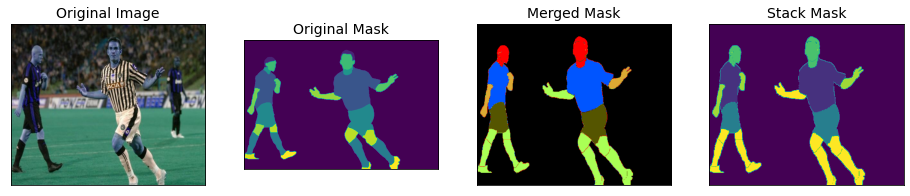

In [123]:
random_index = randrange(100)
random_index = 75

print('image serial: ', random_index)

image_path = get_file_paths_at_index('/content/CIHP/Validation/Images', random_index)[0]
mask_path = get_file_paths_at_index('/content/CIHP/Validation/Category_ids', random_index)[0]

mask_original = cv2.imread(mask_path, cv2.COLOR_BGR2RGB)

image, mask, mask_stack = process_image_and_mask(image_path, mask_path, merged_rgb_color_map, is_allow_merge=True)

print('shape 1:', mask_stack.shape)


fig = plt.figure(figsize=(16, 12))
plt.rc('font', size=15)

fig.add_subplot(1, 4, 1)
  
plt.imshow(image)
plt.title('Original Image', fontdict={'fontsize': 14})

plt.xticks([])
plt.yticks([])

fig.add_subplot(1, 4, 2)

plt.imshow(mask_original)
plt.title('Original Mask', fontdict={'fontsize': 14})

plt.xticks([])
plt.yticks([])

fig.add_subplot(1, 4, 3)

plt.imshow(mask)
plt.title('Merged Mask', fontdict={'fontsize': 14})

plt.xticks([])
plt.yticks([])

# print(mask_stack[0][0])

fig.add_subplot(1, 4, 4)

mask_stack = np.argmax(mask_stack, axis=-1)
mask_stack = mask_stack.astype(np.float32)

plt.imshow(mask_stack)
plt.title('Stack Mask', fontdict={'fontsize': 14})

plt.xticks([])
plt.yticks([])

In [128]:
# we have to create this function for piplining, beacuse when we want to read (decode) tensor object we have to do this in an intermediate function

def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()
        image, _, mask_stack = process_image_and_mask(x, y, color_map = merged_rgb_color_map, is_allow_merge = True)
        return image, mask_stack

    image, mask_stack = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CHANNELS])
    mask_stack.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CLASSES])

    return image, mask_stack

In [129]:
# create the pipeline

def tf_dataset(image_paths, mask_paths, batch_size=32):

  return tf.data.Dataset.from_tensor_slices((image_paths, mask_paths)).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [130]:
train_data_1 = tf_dataset(train_x, train_y, batch_size=BATCH_SIZE_PARSING)
valid_data_1 = tf_dataset(valid_x, valid_y, batch_size=BATCH_SIZE_PARSING)
test_data_1 = tf_dataset(test_x, test_y, batch_size=BATCH_SIZE_PARSING)

train_data_1, valid_data_1, test_data_1

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 8), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 8), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 400, 480, 8), dtype=tf.uint8, name=None))>)

In [150]:
# x, y = test_data_1.take(5)

image_path = [get_file_paths_at_index('/content/CIHP/Validation/Images', 75), get_file_paths_at_index('/content/CIHP/Validation/Images', 70)]
mask_path = [get_file_paths_at_index('/content/CIHP/Validation/Category_ids', 75), get_file_paths_at_index('/content/CIHP/Validation/Category_ids', 70)]

print(image_path, mask_path)

test_x = tf_dataset(image_path, mask_path, batch_size=2)

for x, y in test_x:

  x = x.decode()
  y = y.decode()

  fig = plt.figure(figsize=(16, 12))
  plt.rc('font', size=15)

  fig.add_subplot(1, 2, 1)
  
  plt.imshow(x[0])
  plt.title('Original Image', fontdict={'fontsize': 14})

  plt.xticks([])
  plt.yticks([])

  fig.add_subplot(1, 2, 2)

  mask = np.argmax(y[0], axis=-1)
  mask = mask.astype(np.float32)

  plt.imshow(mask)
  plt.title('Merged Mask', fontdict={'fontsize': 14})

  plt.xticks([])
  plt.yticks([])

  print(y[0].shape)

  break

[['/content/CIHP/Validation/Images/0000870.jpg'], ['/content/CIHP/Validation/Images/0000821.jpg']] [['/content/CIHP/Validation/Category_ids/0000870.png'], ['/content/CIHP/Validation/Category_ids/0000821.png']]


UnknownError: ignored

In [ ]:
# for x, y in valid_data_1.take(1):

#   pred_mask = np.argmax(y[2], axis=-1)
#   pred_mask = pred_mask.astype(np.float32)

#   fig = plt.figure(figsize=(12, 8))

#   fig.add_subplot(1, 2, 1)
#   plt.imshow(x[0])

#   fig.add_subplot(1, 2, 2)
#   plt.imshow(pred_mask)

#   print(x[2], y[2])

#   break

In [ ]:
def pred_human_parsing(image_path, mask_path, color_map, model):

  image,_ , mask_stack = process_image_and_mask(image_path, mask_path, color_map = color_map)

  # visualize_process_image_and_mask(image, mask_stack)

  # make image ready for prediction, we are doing this because for prediciton our data must be inside an array
  image = np.expand_dims(image, axis=0)

  # make mask ready for prediction, this will convery on-hot encoded mask back to grey scale image with values 0-19
  mask_onehot = np.argmax(mask_stack, axis=-1)
  mask_onehot = mask_onehot.astype(np.int32)

  true_mask = mask_onehot

  # make prediction and convert one-hot encoded result to image grey scale 0-19
  pred_mask = model.predict(image, verbose=0)[0]
  pred_mask = np.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask.astype(np.float32)

  return pred_mask, true_mask

In [151]:
%%time

INITIAL_LR = 1e-3
MIN_LR = 1e-6
LR_REDUCTION_FACTOR = 0.1
LR_REUCTION_PATIENCE = 2

EARLY_STOPPING_PATIENCE = 2

EPOCHS = 1
VERBOSE = 2
# BATCH_SIZE_PARSING = 16 # defined as global parameter for human parsing model

# These file names refer to names by which model weights files will be saved or loaded: model_parsing_[model_number]_[saved_file_number]
WEIGHT_FILE_NAME = 'model_parsing_1_2.h5'
MODEL_FILE_NAME = 'model_parsing_1_3.h5'

model_parsing_1 = build_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), n_classes=N_CLASSES)

if run_model_parsing_1:

  model_parsing_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(INITIAL_LR), metrics=['accuracy'])

  callbacks = [
      ModelCheckpoint(os.path.join(saved_models_path, WEIGHT_FILE_NAME), save_best_only=True, save_weights_only=True),
      ReduceLROnPlateau(monitor='val_loss', factor=LR_REDUCTION_FACTOR, patience=LR_REUCTION_PATIENCE, min_lr=MIN_LR),
      EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE),
  ]

  model_parsing_1.fit(train_data_1, steps_per_epoch=len(train_data_1),
                      validation_data=valid_data_1, validation_steps=len(valid_data_1),
                      epochs=EPOCHS, verbose=VERBOSE, batch_size=BATCH_SIZE_PARSING, callbacks=callbacks)
  
  model_parsing_1.save(os.path.join(saved_models_path, MODEL_FILE_NAME))

else:

  # currently we are using saved model as model weight file
  model_parsing_1 = load_model(os.path.join(saved_models_path, WEIGHT_FILE_NAME))

model_parsing_1.summary()

# visualize a plot of model
# tf.keras.utils.plot_model(model_parsing_0, show_shapes=True,)

KerasTensor(type_spec=TensorSpec(shape=(None, 400, 480, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 400, 480, 8), dtype=tf.float32, name=None), name='activation_18/Softmax:0', description="created by layer 'activation_18'")
Model: "human_parsing_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 400, 480, 64  1792        ['input_1[0][0]']                
                                )                     

OSError: ignored

In [ ]:
# plot_and_predict_model(merged_rgb_color_map, merged_class_labels, model_parsing_1)